
# Gaussian Processes regression: basic introductory example

A simple one-dimensional regression example computed in two different ways:

1. A noise-free case
2. A noisy case with known noise-level per datapoint

In both cases, the kernel's parameters are estimated using the maximum
likelihood principle.

The figures illustrate the interpolating property of the Gaussian Process model
as well as its probabilistic nature in the form of a pointwise 95% confidence
interval.

Note that `alpha` is a parameter to control the strength of the Tikhonov
regularization on the assumed training points' covariance matrix.


In [1]:
# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#         Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause

## Dataset generation

We will start by generating a synthetic dataset. The true generative process
is defined as $f(x) = x \sin(x)$.



In [2]:
import numpy as np

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

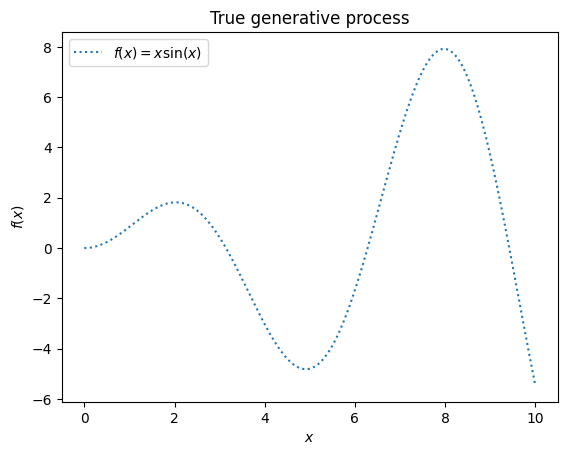

In [3]:
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

We will use this dataset in the next experiment to illustrate how Gaussian
Process regression is working.

## Example with noise-free target

In this first example, we will use the true generative process without
adding any noise. For training the Gaussian Process regression, we will only
select few samples.



In [4]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]
print(len(X_train))
print(X_train)

6
[[5.07507508]
 [8.18818819]
 [4.52452452]
 [3.68368368]
 [2.42242242]
 [9.2992993 ]]


Now, we fit a Gaussian process on these few training data samples. We will
use a radial basis function (RBF) kernel and a constant parameter to fit the
amplitude.



In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.02**2 * RBF(length_scale=1.43)

After fitting our model, we see that the hyperparameters of the kernel have
been optimized. Now, we will use our kernel to compute the mean prediction
of the full dataset and plot the 95% confidence interval.



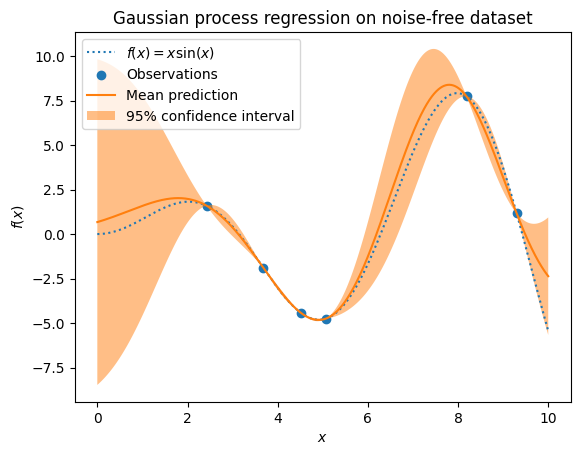

In [6]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

We see that for a prediction made on a data point close to the one from the
training set, the 95% confidence has a small amplitude. Whenever a sample
falls far from training data, our model's prediction is less accurate and the
model prediction is less precise (higher uncertainty).

## Example with noisy targets

We can repeat a similar experiment adding an additional noise to the target
this time. It will allow seeing the effect of the noise on the fitted model.

We add some random Gaussian noise to the target with an arbitrary
standard deviation.



In [7]:
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

We create a similar Gaussian process model. In addition to the kernel, this
time, we specify the parameter `alpha` which can be interpreted as the
variance of a Gaussian noise.



In [8]:
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
)
print(kernel)
gaussian_process.fit(X_train, y_train_noisy)
print(gaussian_process.kernel_)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

1**2 * RBF(length_scale=1)
4.28**2 * RBF(length_scale=1.1)


Let's plot the mean prediction and the uncertainty region as before.



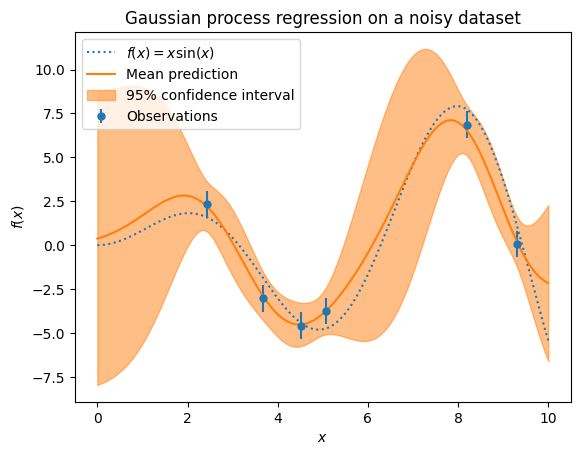

In [9]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

The noise affects the predictions close to the training samples: the
predictive uncertainty near to the training samples is larger because we
explicitly model a given level target noise independent of the input
variable.

